`Last update at 2021-05-08`

# Background

## Rounds to test

Number of samples:
```
Round 1 - 60 cyanobacterial samples
Round 2 - 129 PoDP genomes downloaded automatically
Round 3 - 129 PoDP genomes downloaded automatically + 450 metagenomes (a total of 579)
Round 4 - 326 PoDP genomes (downloaded automatically and manually) + 680 metagenomes (a total of 1006)
```
Number of validated links:
```
Round 1 - 39 BGC-MS/MS links (1 correct link)
Round 2 - 1 BGC-MS/MS links (0 correct link)
Round 3 - 16 BGC-MS/MS links (8 correct links)
Round 4 - 18 BGC-MS/MS links (9 correct links)
```

## Outline

```
    2) Creating MS/MS fingerprints:
    2.1) Compares all fragmentation spectra of a raw file to all reference spectra of a list;
    2.2) Run the search for all mzXML files of a specified directory; (estimated runtime of 29:04:27)
    2.3) Creating MS/MS fingerprints matrix (ispec_mat);
    2.4) Merging columns from same sample.
    
```

In [1]:
from pyteomics import mzxml
from pyteomics import mgf
from spectrum_alignment import *
import numpy as np
import pandas as pd
import subprocess
import os
import glob
import requests
import json
import time

# 2. Creating MS/MS fingerprints

## 2.1. Compares all fragmentation spectra of a raw file to all reference spectra of a list

In [2]:
def get_ms2df(file_name, speclist, pmztol=0.1, fragtol=0.1):
    rt = []
    mz = []
    inten = []
    prec_mz = []
    scan_num = []
    scores = []
    specids = []
    pmlist = []
    for spec in speclist:
        for k,v in spec.items():
            pmlist.append(v[0])
    pmlist = np.array(pmlist)
    with mzxml.read(file_name) as reader:
        for spectrum in reader:
                if spectrum['msLevel'] == 2:
                    p_mz = spectrum['precursorMz'][0].get('precursorMz')
                    loc = np.where(abs(pmlist-p_mz) < pmztol)[0]
                    if len(loc):
                        for i in loc:
                            qmz = spectrum['m/z array']
                            qint = spectrum['intensity array']
                            qspec = list(zip(qmz, qint))
                            pm1, spec1 = list(speclist[i].values())[0]
                            specid = list(speclist[i].keys())[0]
                            score = score_alignment(spec1, qspec, pm1, p_mz, fragtol)[0]
                            if score>0:
                                lqmz = len(qmz)
                                scan_num.extend([spectrum['num']] * lqmz)
                                rt.extend([spectrum['retentionTime']] * lqmz)
                                mz.extend(qmz)
                                inten.extend(qint)
                                prec_mz.extend([p_mz] * lqmz)
                                scores.extend([score] * lqmz)
                                specids.extend([specid] * lqmz)

    ms2_data = pd.DataFrame(
            {'prec_mz': prec_mz,
             'mz': mz,
             'inten': inten,
             'rt': rt,
             'scan_num': scan_num,
             'specids': specids,
             'scores': scores
            })
    return ms2_data

def get_library(lib, peaks=False):
    base_url = "gnps.ucsd.edu"
    if peaks:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib + '&showpeaks=true'
    else:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib
    json_obj = json.loads(requests.get(datasets_url).text)
    return json_obj['spectra']


In [3]:
libnames = pd.DataFrame(get_library('all'))
libnames.head()

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Pubmed_ID,Smiles,INCHI,INCHI_AUX,Library_Class,SpectrumID,Ion_Mode,create_time,task_id,user_id
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-0w2a-0001282259-0001282259,mwang87,...,N/A,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,N/A,N/A,1,CCMSLIB00000001547,Positive,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,null
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-00dl-0000011189-0000011189,mwang87,...,N/A,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,N/A,1,CCMSLIB00000001548,Positive,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,null
2,CCMSLIB00000001549,20111105_Jenia_Ger_MalyngamideC_MH_456_qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-00di-0000900000-0000900000,mwang87,...,N/A,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,InChI=1S/C24H38ClNO5/c1-3-4-5-6-8-11-19(30-2)1...,N/A,1,CCMSLIB00000001549,Positive,2021-03-18 16:28:20.0,48c1656fa4464fea93b71bfd79e0faa5,null
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-0002-0000190000-0000190000,mwang87,...,N/A,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,1,CCMSLIB00000001550,Positive,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,null
4,CCMSLIB00000001551,A1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,null,splash10-03di-0910000000-0910000000,mwang87,...,N/A,N/A,N/A,N/A,1,CCMSLIB00000001551,Positive,2014-02-04 17:56:31.0,d14a5843653040ba9fa2c4376f2be358,null


In [4]:
# Creates a list of reference spectra from mgf files stored in specified directory
fmgf = [x for x in os.listdir('selected_mgf_round4/') if '.mgf' in x]

speclist = []
for i in range(len(fmgf)):
    with mgf.MGF('selected_mgf_round4/%s' % fmgf[i]) as reader: 
        for spectrum in reader:
            speclist.append({fmgf[i][:18] : [spectrum['params']['pepmass'][0], 
                                            list(zip(spectrum['m/z array'], spectrum['intensity array']))]
                            } 
            )


In [5]:
len(glob.glob('/Volumes/TFL210426/podp_LCMS/*'))

3248

## 2.2. Run the search for all mzXML files of a specified directory

In [6]:
start = time.time()

dirlist = glob.glob('/Volumes/TFL210426/podp_LCMS/*')

mxlist,excluded_list = [],[]
for dr in dirlist:
    print(dr)
    try:
        ms2_data = get_ms2df(dr, speclist)
        mxlist.append(ms2_data.loc[ms2_data.groupby(['scan_num'])['scores'].idxmax()])
    except:
        excluded_list.append(dr)
        
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

/Volumes/TFL210426/podp_LCMS/ERS4341365.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.7
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.8
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.9
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.10
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.11
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.12
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.13
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.14
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.15
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.16
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.17
/Volumes/TFL210426/podp_LCMS/GCA_000240165.mzXML.18
/Volumes/TFL210426/podp_L

/Volumes/TFL210426/podp_LCMS/GCA_000414585.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000414565.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000414525.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000414505.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000414485.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000414445.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000414425.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000218465.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000712235.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000244855.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000233535.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000214475.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000234075.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000183585.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000763055.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000158375.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000147235.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000090945.mzXML.1
/Volumes/TFL210426/podp_LCMS/GCA_000209465.mzXML.1
/Volumes/TFL210426/podp_LCMS/GC

/Volumes/TFL210426/podp_LCMS/GCA_000712235.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000244855.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000233535.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000214475.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000234075.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000183585.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000763055.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000158375.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000147235.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000090945.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000209465.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000273605.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000277625.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000287675.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000162275.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000478945.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000517705.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000524395.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000294005.mzXML.2
/Volumes/TFL210426/podp_LCMS/GC

/Volumes/TFL210426/podp_LCMS/GCA_000261205.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000411435.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000513015.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000466465.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414705.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414685.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414665.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414645.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414625.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414605.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414585.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414565.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414525.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414505.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414485.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414445.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000414425.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000218465.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000712235.mzXML.3
/Volumes/TFL210426/podp_LCMS/GC

/Volumes/TFL210426/podp_LCMS/GCA_000414625.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414605.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414585.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414565.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414525.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414505.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414485.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414445.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000414425.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000218465.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000712235.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000244855.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000233535.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000214475.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000234075.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000183585.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000763055.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000158375.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000147235.mzXML.4
/Volumes/TFL210426/podp_LCMS/GC

/Volumes/TFL210426/podp_LCMS/GCA_000087965.mzXML.9
/Volumes/TFL210426/podp_LCMS/GCA_000087965.mzXML.10
/Volumes/TFL210426/podp_LCMS/GCA_002941025.mzML.1
/Volumes/TFL210426/podp_LCMS/GCA_000506385.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000506385.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000012265.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_003324555.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_000012445.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_001562525.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_002899455.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_003248315.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_001625105.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_001625105.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000377965.mzXML.2
/Volumes/TFL210426/podp_LCMS/GCA_009711925.mzML.1
/Volumes/TFL210426/podp_LCMS/GCA_000377965.mzXML.3
/Volumes/TFL210426/podp_LCMS/GCA_000377965.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000377965.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000377965.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA

/Volumes/TFL210426/podp_LCMS/GCA_000424765.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000424765.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000424785.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000424785.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000424785.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000514995.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000514995.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000514995.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000377145.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000377145.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000377145.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000377545.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000377545.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000377545.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000377165.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000377165.mzXML.5
/Volumes/TFL210426/podp_LCMS/GCA_000377165.mzXML.6
/Volumes/TFL210426/podp_LCMS/GCA_000213055.mzXML.4
/Volumes/TFL210426/podp_LCMS/GCA_000213055.mzXML.5
/Volumes/TFL210426/podp_LCMS/GC

/Volumes/TFL210426/podp_LCMS/ERS4341368.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341369.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341370.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341371.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341372.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341373.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341374.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341375.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341376.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341377.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341378.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341379.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341380.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341381.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341382.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341383.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341384.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341385.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341386.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341387.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341388.

/Volumes/TFL210426/podp_LCMS/ERS4341544.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341545.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341546.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341547.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341548.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341549.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341550.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341551.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341552.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341553.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341555.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341556.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341557.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341558.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341560.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341561.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341562.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341563.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341564.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341565.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4341566.

/Volumes/TFL210426/podp_LCMS/ERS4346406.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346409.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346410.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346411.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346412.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346413.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346414.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346415.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346417.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346418.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346419.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346420.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346421.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346422.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346423.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346424.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346425.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346426.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346427.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346428.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4346429.

/Volumes/TFL210426/podp_LCMS/ERS4346598.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356164.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356166.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356177.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356239.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356178.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356183.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356185.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356188.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356189.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356195.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356200.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356203.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356204.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356211.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356215.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356219.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356225.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356227.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356234.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERS4356237.

/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.1
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.2
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.3
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.4
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.5
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.6
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.7
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.8
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.9
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.10
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.11
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.12
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.3
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.4
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.5
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.6
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.7
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.8
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.9
/Volumes/TFL210426/podp_LCMS/2518285561.mzXML.10
/Volumes/TFL210426/podp_LCMS/2518285

/Volumes/TFL210426/podp_LCMS/SspOBRC6v1.mzXML.3
/Volumes/TFL210426/podp_LCMS/SspBS21v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/SspBS21v1.mzXML.2
/Volumes/TFL210426/podp_LCMS/SspBS21v1.mzXML.3
/Volumes/TFL210426/podp_LCMS/VspACP1v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/CspBV3AC2v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/CspBV3AC2v1.mzXML.2
/Volumes/TFL210426/podp_LCMS/CspBV3AC2v1.mzXML.3
/Volumes/TFL210426/podp_LCMS/BspMSTE12v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/BspMSTE12v1.mzXML.2
/Volumes/TFL210426/podp_LCMS/BspMSTE12v1.mzXML.3
/Volumes/TFL210426/podp_LCMS/FspCM21v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/FspCM21v1.mzXML.2
/Volumes/TFL210426/podp_LCMS/FspCM21v1.mzXML.3
/Volumes/TFL210426/podp_LCMS/FspCM22v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/FspCM22v1.mzXML.2
/Volumes/TFL210426/podp_LCMS/FspOBRC1v1.mzXML.1
/Volumes/TFL210426/podp_LCMS/FspOBRC1v1.mzXML.2
/Volumes/TFL210426/podp_LCMS/SspBS29av1.mzXML.1
/Volumes/TFL210426/podp_LCMS/SspBS29av1.mzXML.2
/Volumes/TFL210426/podp_LCMS/SspBS29av1.mzX

/Volumes/TFL210426/podp_LCMS/GCA_009711935.mzML.1
/Volumes/TFL210426/podp_LCMS/GCA_009712075.mzML.1
/Volumes/TFL210426/podp_LCMS/GCA_009712065.mzML.1
/Volumes/TFL210426/podp_LCMS/2516493032.mzXML.3
/Volumes/TFL210426/podp_LCMS/2516493032.mzXML.4
/Volumes/TFL210426/podp_LCMS/2516493032.mzXML.5
/Volumes/TFL210426/podp_LCMS/2515154094.mzXML.1
/Volumes/TFL210426/podp_LCMS/2515154094.mzXML.2
/Volumes/TFL210426/podp_LCMS/2515154094.mzXML.3
/Volumes/TFL210426/podp_LCMS/2524614807.mzXML.16
/Volumes/TFL210426/podp_LCMS/2524614807.mzXML.17
/Volumes/TFL210426/podp_LCMS/2524614807.mzXML.18
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.14
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.15
/Volumes/TFL210426/podp_LCMS/2515154124.mzXML.16
/Volumes/TFL210426/podp_LCMS/2517287023.mzXML.3
/Volumes/TFL210426/podp_LCMS/2517287023.mzXML.4
/Volumes/TFL210426/podp_LCMS/2517287023.mzXML.5
/Volumes/TFL210426/podp_LCMS/2517572194.mzXML.3
/Volumes/TFL210426/podp_LCMS/2517572194.mzXML.4
/Volumes/TFL210426/podp_LCMS

/Volumes/TFL210426/podp_LCMS/2531839422.mzXML.1
/Volumes/TFL210426/podp_LCMS/2531839222.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561671.mzXML.1
/Volumes/TFL210426/podp_LCMS/2531839427.mzXML.1
/Volumes/TFL210426/podp_LCMS/2531839428.mzXML.1
/Volumes/TFL210426/podp_LCMS/2531839429.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561817.mzXML.1
/Volumes/TFL210426/podp_LCMS/2531839226.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561743.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561675.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561678.mzXML.1
/Volumes/TFL210426/podp_LCMS/2531839319.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561819.mzXML.1
/Volumes/TFL210426/podp_LCMS/2529292847.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561822.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561586.mzXML.1
/Volumes/TFL210426/podp_LCMS/2534682005.mzXML.1
/Volumes/TFL210426/podp_LCMS/2529292952.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561677.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561583.mzXML.1
/Volumes/TFL210426/podp_LCMS/2537561578.

/Volumes/TFL210426/podp_LCMS/647533241.mzXML.2
/Volumes/TFL210426/podp_LCMS/645058700.mzXML.2
/Volumes/TFL210426/podp_LCMS/647533196.mzXML.2
/Volumes/TFL210426/podp_LCMS/2541047008.mzXML.2
/Volumes/TFL210426/podp_LCMS/2541047009.mzXML.2
/Volumes/TFL210426/podp_LCMS/645951836.mzXML.2
/Volumes/TFL210426/podp_LCMS/645951806.mzXML.2
/Volumes/TFL210426/podp_LCMS/2541046992.mzXML.3
/Volumes/TFL210426/podp_LCMS/2541047574.mzXML.3
/Volumes/TFL210426/podp_LCMS/2600255234.mzXML.3
/Volumes/TFL210426/podp_LCMS/643886104.mzXML.3
/Volumes/TFL210426/podp_LCMS/2531839498.mzXML.3
/Volumes/TFL210426/podp_LCMS/647533111.mzXML.3
/Volumes/TFL210426/podp_LCMS/647533114.mzXML.3
/Volumes/TFL210426/podp_LCMS/645058788.mzXML.3
/Volumes/TFL210426/podp_LCMS/649989912.mzXML.3
/Volumes/TFL210426/podp_LCMS/651324012.mzXML.3
/Volumes/TFL210426/podp_LCMS/646206272.mzXML.3
/Volumes/TFL210426/podp_LCMS/2562617184.mzXML.3
/Volumes/TFL210426/podp_LCMS/649989914.mzXML.3
/Volumes/TFL210426/podp_LCMS/646206263.mzXML.3
/Volum

/Volumes/TFL210426/podp_LCMS/646206258.mzXML.4
/Volumes/TFL210426/podp_LCMS/649989916.mzXML.4
/Volumes/TFL210426/podp_LCMS/2597489878.mzXML.4
/Volumes/TFL210426/podp_LCMS/649989923.mzXML.4
/Volumes/TFL210426/podp_LCMS/2529292987.mzXML.4
/Volumes/TFL210426/podp_LCMS/2529292986.mzXML.4
/Volumes/TFL210426/podp_LCMS/647533110.mzXML.4
/Volumes/TFL210426/podp_LCMS/640963015.mzXML.4
/Volumes/TFL210426/podp_LCMS/2531839305.mzXML.4
/Volumes/TFL210426/podp_LCMS/2531839306.mzXML.4
/Volumes/TFL210426/podp_LCMS/2531839304.mzXML.4
/Volumes/TFL210426/podp_LCMS/2537562062.mzXML.4
/Volumes/TFL210426/podp_LCMS/2531839307.mzXML.4
/Volumes/TFL210426/podp_LCMS/2537561756.mzXML.4
/Volumes/TFL210426/podp_LCMS/2537561665.mzXML.4
/Volumes/TFL210426/podp_LCMS/2531839301.mzXML.4
/Volumes/TFL210426/podp_LCMS/2547132079.mzXML.4
/Volumes/TFL210426/podp_LCMS/2531839303.mzXML.4
/Volumes/TFL210426/podp_LCMS/2534681605.mzXML.4
/Volumes/TFL210426/podp_LCMS/2529293058.mzXML.4
/Volumes/TFL210426/podp_LCMS/2534682202.mzXML

/Volumes/TFL210426/podp_LCMS/ERX2291696.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291596.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291697.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291698.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291699.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291700.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291702.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291703.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291704.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291705.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291706.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291351.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291597.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291707.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291708.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291709.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291710.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291711.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291712.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291713.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291353.

/Volumes/TFL210426/podp_LCMS/ERX2291764.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291765.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291766.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291767.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291768.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291769.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291770.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291771.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291617.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291772.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291299.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291773.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291774.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291775.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291776.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291777.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291778.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291779.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291780.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291781.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291618.

/Volumes/TFL210426/podp_LCMS/ERX2291920.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291921.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291923.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291924.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291925.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291928.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291929.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291930.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291931.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291932.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291933.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291934.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291935.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291937.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291938.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291939.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291940.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291941.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291942.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291950.mzXML.1
/Volumes/TFL210426/podp_LCMS/ERX2291951.

In [7]:
refn = [x[:-4] for x in fmgf]
specn = os.listdir("/Volumes/TFL210426/podp_LCMS/")

In [8]:
len(excluded_list),len(specn)

(385, 3775)

In [9]:
clean_excluded_list = []

for item in excluded_list:
    clean_excluded_list.append(os.path.basename(item))
    
len(clean_excluded_list)

385

In [10]:
filt_specn = []

for item in specn:
    if '._' not in item:
        if item not in clean_excluded_list:
            filt_specn.append(item)
        
len(filt_specn)

2863

## 2.3. Creating MS/MS fingerprints matrix (ispec_mat)

In [11]:
# create empty data frame using the names above as indexes
ispec_mat = pd.DataFrame(0, index=refn, columns=filt_specn)

In [12]:
# Fill the matrix with the highest score for a given reference spectrum in a givem sample
for i in range(len(filt_specn)):
    mtmp = mxlist[i].loc[mxlist[i].groupby(['specids'])['scores'].idxmax()]
    ispec_mat.loc[mtmp['specids'], filt_specn[i]] = mtmp['scores'].tolist()

In [13]:
ispec_mat

,ERS4341365.mzXML.1,GCA_000240165.mzXML.1,GCA_000240165.mzXML.2,GCA_000240165.mzXML.3,GCA_011290345.mzXML.1,GCA_011290345.mzXML.2,GCA_011290345.mzXML.3,GCA_000506385.mzXML.1,GCA_000506385.mzXML.2,GCA_000012265.mzXML.1,...,2561511112.mzXML.5,2561511112.mzXML.6,2517572165.mzXML.4,2517572165.mzXML.5,2517572165.mzXML.6,2751185827.mzXML.1,2751185827.mzXML.2,2751185827.mzXML.3,2767802005.mzXML.1,GCA_000377965.mzXML.1
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000566828,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004679300,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.874688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681487,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00005436037,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.672732,0.597155,0.705189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000566944,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000571948,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000571961,0.0,0.0,0.0,0.0,0.0,0.00606,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681475,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
(ispec_mat>0.7).sum().sum()

780

In [15]:
ispec_mat.shape

(148, 2863)

In [16]:
ispec_mat = ispec_mat[(ispec_mat.T != 0).any()]

In [17]:
ispec_mat = ispec_mat.fillna(0)

ispec_mat

,ERS4341365.mzXML.1,GCA_000240165.mzXML.1,GCA_000240165.mzXML.2,GCA_000240165.mzXML.3,GCA_011290345.mzXML.1,GCA_011290345.mzXML.2,GCA_011290345.mzXML.3,GCA_000506385.mzXML.1,GCA_000506385.mzXML.2,GCA_000012265.mzXML.1,...,2561511112.mzXML.5,2561511112.mzXML.6,2517572165.mzXML.4,2517572165.mzXML.5,2517572165.mzXML.6,2751185827.mzXML.1,2751185827.mzXML.2,2751185827.mzXML.3,2767802005.mzXML.1,GCA_000377965.mzXML.1
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCMSLIB00000566828,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCMSLIB00004679300,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.874688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCMSLIB00004681487,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCMSLIB00005436037,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.672732,0.597155,0.705189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00003739957,0.0,0.0,0.0,0.0,0.028674,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109049
CCMSLIB00000566944,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCMSLIB00000571961,0.0,0.0,0.0,0.0,0.000000,0.00606,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCMSLIB00004681475,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [18]:
ispec_mat.shape

(122, 2863)

In [26]:
lib_df = libnames.loc[libnames['SpectrumID'].isin(refn), ['Compound_Name', 'SpectrumID']]

lib_df.to_csv('./outputs/libnames-round4-TFL210427.tsv',sep='\t')

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


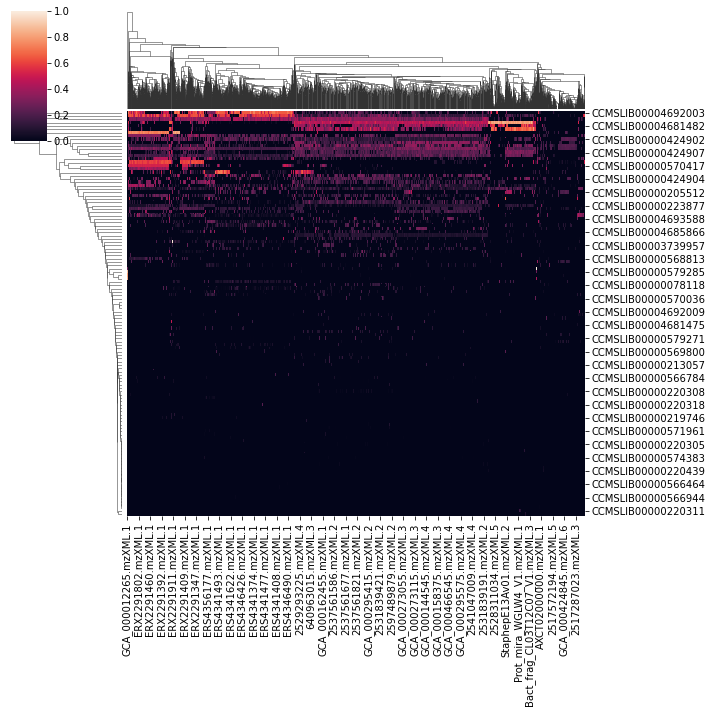

In [20]:
import seaborn as sns

sns.clustermap(ispec_mat)

In [21]:
strain_count = []

for item in ispec_mat.columns:
    strain = item.split('.')[0]
    if strain not in strain_count:
        strain_count.append(strain)
        
len(strain_count)

1531

## 2.4. Merging columns from same sample

In [22]:
ispec_mat_trans = ispec_mat.T
processed_list = []

merged_ispec_mat = pd.DataFrame()

for i,r in ispec_mat_trans.iterrows():
    strain = i.split('.')[0]
    if strain not in processed_list:
        print(i,strain)
        processed_list.append(strain)
        ispec_temp = ispec_mat_trans[ispec_mat_trans.index.map(lambda x: strain in x)]
        if len(ispec_temp) == 1:
            merged_ispec_mat[strain] = ispec_temp.loc[ispec_temp.index[0], :].values.tolist()
        else:
            merged_ispec_mat[strain] = list(ispec_temp.max(axis=0))

ERS4341365.mzXML.1 ERS4341365
GCA_000240165.mzXML.1 GCA_000240165
GCA_011290345.mzXML.1 GCA_011290345
GCA_000506385.mzXML.1 GCA_000506385
GCA_000012265.mzXML.1 GCA_000012265
GCA_003324555.mzXML.1 GCA_003324555
GCA_000012445.mzXML.1 GCA_000012445
GCA_001562525.mzXML.1 GCA_001562525
GCA_002899455.mzXML.1 GCA_002899455
GCA_003248315.mzXML.1 GCA_003248315
GCA_001625105.mzXML.1 GCA_001625105
GCA_000710405.mzXML.1 GCA_000710405
GCA_000413395.mzXML.1 GCA_000413395
GCA_000466545.mzXML.1 GCA_000466545
GCA_000466585.mzXML.1 GCA_000466585
GCA_000160635.mzXML.1 GCA_000160635
GCA_000214315.mzXML.1 GCA_000214315
GCA_000162155.mzXML.1 GCA_000162155
GCA_000162215.mzXML.1 GCA_000162215
GCA_000157015.mzXML.1 GCA_000157015
GCA_000273465.mzXML.1 GCA_000273465
GCA_000218325.mzXML.1 GCA_000218325
GCA_000159875.mzXML.1 GCA_000159875
GCA_000175315.mzXML.1 GCA_000175315
GCA_000185585.mzXML.1 GCA_000185585
GCA_000157075.mzXML.1 GCA_000157075
GCA_000159075.mzXML.1 GCA_000159075
GCA_000158335.mzXML.1 GCA_00015833

ERS4341431.mzXML.1 ERS4341431
ERS4341432.mzXML.1 ERS4341432
ERS4341433.mzXML.1 ERS4341433
ERS4341434.mzXML.1 ERS4341434
ERS4341435.mzXML.1 ERS4341435
ERS4341436.mzXML.1 ERS4341436
ERS4341437.mzXML.1 ERS4341437
ERS4341438.mzXML.1 ERS4341438
ERS4341439.mzXML.1 ERS4341439
ERS4341440.mzXML.1 ERS4341440
ERS4341441.mzXML.1 ERS4341441
ERS4341442.mzXML.1 ERS4341442
ERS4341443.mzXML.1 ERS4341443
ERS4341444.mzXML.1 ERS4341444
ERS4341445.mzXML.1 ERS4341445
ERS4341446.mzXML.1 ERS4341446
ERS4341447.mzXML.1 ERS4341447
ERS4341448.mzXML.1 ERS4341448
ERS4341449.mzXML.1 ERS4341449
ERS4341450.mzXML.1 ERS4341450
ERS4341451.mzXML.1 ERS4341451
ERS4341452.mzXML.1 ERS4341452
ERS4341453.mzXML.1 ERS4341453
ERS4341454.mzXML.1 ERS4341454
ERS4341455.mzXML.1 ERS4341455
ERS4341456.mzXML.1 ERS4341456
ERS4341457.mzXML.1 ERS4341457
ERS4341458.mzXML.1 ERS4341458
ERS4341459.mzXML.1 ERS4341459
ERS4341460.mzXML.1 ERS4341460
ERS4341461.mzXML.1 ERS4341461
ERS4341462.mzXML.1 ERS4341462
ERS4341463.mzXML.1 ERS4341463
ERS4341464

ERS4346490.mzXML.1 ERS4346490
ERS4346492.mzXML.1 ERS4346492
ERS4346493.mzXML.1 ERS4346493
ERS4346494.mzXML.1 ERS4346494
ERS4346496.mzXML.1 ERS4346496
ERS4346497.mzXML.1 ERS4346497
ERS4346498.mzXML.1 ERS4346498
ERS4346499.mzXML.1 ERS4346499
ERS4346500.mzXML.1 ERS4346500
ERS4346501.mzXML.1 ERS4346501
ERS4346502.mzXML.1 ERS4346502
ERS4346503.mzXML.1 ERS4346503
ERS4346504.mzXML.1 ERS4346504
ERS4346505.mzXML.1 ERS4346505
ERS4346506.mzXML.1 ERS4346506
ERS4346507.mzXML.1 ERS4346507
ERS4346509.mzXML.1 ERS4346509
ERS4346510.mzXML.1 ERS4346510
ERS4346511.mzXML.1 ERS4346511
ERS4346512.mzXML.1 ERS4346512
ERS4346513.mzXML.1 ERS4346513
ERS4346514.mzXML.1 ERS4346514
ERS4346515.mzXML.1 ERS4346515
ERS4346516.mzXML.1 ERS4346516
ERS4346517.mzXML.1 ERS4346517
ERS4346519.mzXML.1 ERS4346519
ERS4346520.mzXML.1 ERS4346520
ERS4346522.mzXML.1 ERS4346522
ERS4346523.mzXML.1 ERS4346523
ERS4346524.mzXML.1 ERS4346524
ERS4346525.mzXML.1 ERS4346525
ERS4346527.mzXML.1 ERS4346527
ERS4346528.mzXML.1 ERS4346528
ERS4346529

2541047014.mzXML.1 2541047014
2558860922.mzXML.1 2558860922
2600255042.mzXML.1 2600255042
2541047559.mzXML.1 2541047559
2541047560.mzXML.1 2541047560
2541047561.mzXML.1 2541047561
2541047562.mzXML.1 2541047562
2541047563.mzXML.1 2541047563
2541047564.mzXML.1 2541047564
2541047565.mzXML.1 2541047565
2541047566.mzXML.1 2541047566
2541047568.mzXML.1 2541047568
2541047569.mzXML.1 2541047569
2541047570.mzXML.1 2541047570
2541047572.mzXML.1 2541047572
2541047573.mzXML.1 2541047573
651324049.mzXML.1 651324049
2513237364.mzXML.1 2513237364
2513237359.mzXML.1 2513237359
651324085.mzXML.1 651324085
2531839191.mzXML.1 2531839191
649989921.mzXML.1 649989921
2597489879.mzXML.1 2597489879
646206260.mzXML.1 646206260
649989942.mzXML.1 649989942
648861011.mzXML.1 648861011
651324056.mzXML.1 651324056
2537561939.mzXML.1 2537561939
2524023211.mzXML.1 2524023211
2537561881.mzXML.1 2537561881
646206279.mzXML.1 646206279
2558860390.mzXML.1 2558860390
2558860924.mzXML.1 2558860924
2558860926.mzXML.1 2558860

ERX2291787.mzXML.1 ERX2291787
ERX2291788.mzXML.1 ERX2291788
ERX2291789.mzXML.1 ERX2291789
ERX2291790.mzXML.1 ERX2291790
ERX2291791.mzXML.1 ERX2291791
ERX2291792.mzXML.1 ERX2291792
ERX2291793.mzXML.1 ERX2291793
ERX2291794.mzXML.1 ERX2291794
ERX2291795.mzXML.1 ERX2291795
ERX2291796.mzXML.1 ERX2291796
ERX2291463.mzXML.1 ERX2291463
ERX2291464.mzXML.1 ERX2291464
ERX2291797.mzXML.1 ERX2291797
ERX2291620.mzXML.1 ERX2291620
ERX2291798.mzXML.1 ERX2291798
ERX2291799.mzXML.1 ERX2291799
ERX2291800.mzXML.1 ERX2291800
ERX2291466.mzXML.1 ERX2291466
ERX2291621.mzXML.1 ERX2291621
ERX2291622.mzXML.1 ERX2291622
ERX2291801.mzXML.1 ERX2291801
ERX2291467.mzXML.1 ERX2291467
ERX2291469.mzXML.1 ERX2291469
ERX2291470.mzXML.1 ERX2291470
ERX2291802.mzXML.1 ERX2291802
ERX2291803.mzXML.1 ERX2291803
ERX2291804.mzXML.1 ERX2291804
ERX2291805.mzXML.1 ERX2291805
ERX2291806.mzXML.1 ERX2291806
ERX2291807.mzXML.1 ERX2291807
ERX2291808.mzXML.1 ERX2291808
ERX2291809.mzXML.1 ERX2291809
ERX2291810.mzXML.1 ERX2291810
ERX2291811

In [23]:
ispec_mat_trans[ispec_mat_trans.index.map(lambda x: 'GCA_000240165' in x)]

,CCMSLIB00000567505,CCMSLIB00000566828,CCMSLIB00004679300,CCMSLIB00004681487,CCMSLIB00005436037,CCMSLIB00000566784,CCMSLIB00000568582,CCMSLIB00000574381,CCMSLIB00004681486,CCMSLIB00004692003,...,CCMSLIB00000205512,CCMSLIB00005435929,CCMSLIB00000220433,CCMSLIB00000839203,CCMSLIB00000220431,CCMSLIB00003739957,CCMSLIB00000566944,CCMSLIB00000571961,CCMSLIB00004681475,CCMSLIB00000579285
GCA_000240165.mzXML.1,0.0,0.0,0.0,0.0,0.0,0.0,0.113836,0.0,0.0,0.0,...,0.154602,0.0,0.0,0.144379,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.48,0.0,0.0,0.0,0.0,0.0,0.0,0.113836,0.0,0.0,0.0,...,0.154602,0.0,0.0,0.144379,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.49,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.50,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
merged_ispec_mat.index = list(ispec_mat.index)

merged_ispec_mat

,ERS4341365,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERX2291662,ERX2291663,ERX2291664,ERX2291665,ERX2291666,ERX2291667,2561511112,2517572165,2751185827,2767802005
CCMSLIB00000567505,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000566828,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004679300,0.0,0.0,0.000000,0.000000,0.874688,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681487,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00005436037,0.0,0.0,0.000000,0.672732,0.705189,0.649431,0.702502,0.647007,0.651388,0.636056,...,0.370474,0.218296,0.425436,0.276767,0.356659,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00003739957,0.0,0.0,0.028674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000566944,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000571961,0.0,0.0,0.006060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681475,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [25]:
len(merged_ispec_mat.columns)

1531

In [27]:
merged_ispec_mat.to_csv("./outputs/mass-affinity_df-round4-TFL210426.txt",sep="\t",index_label=False)

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


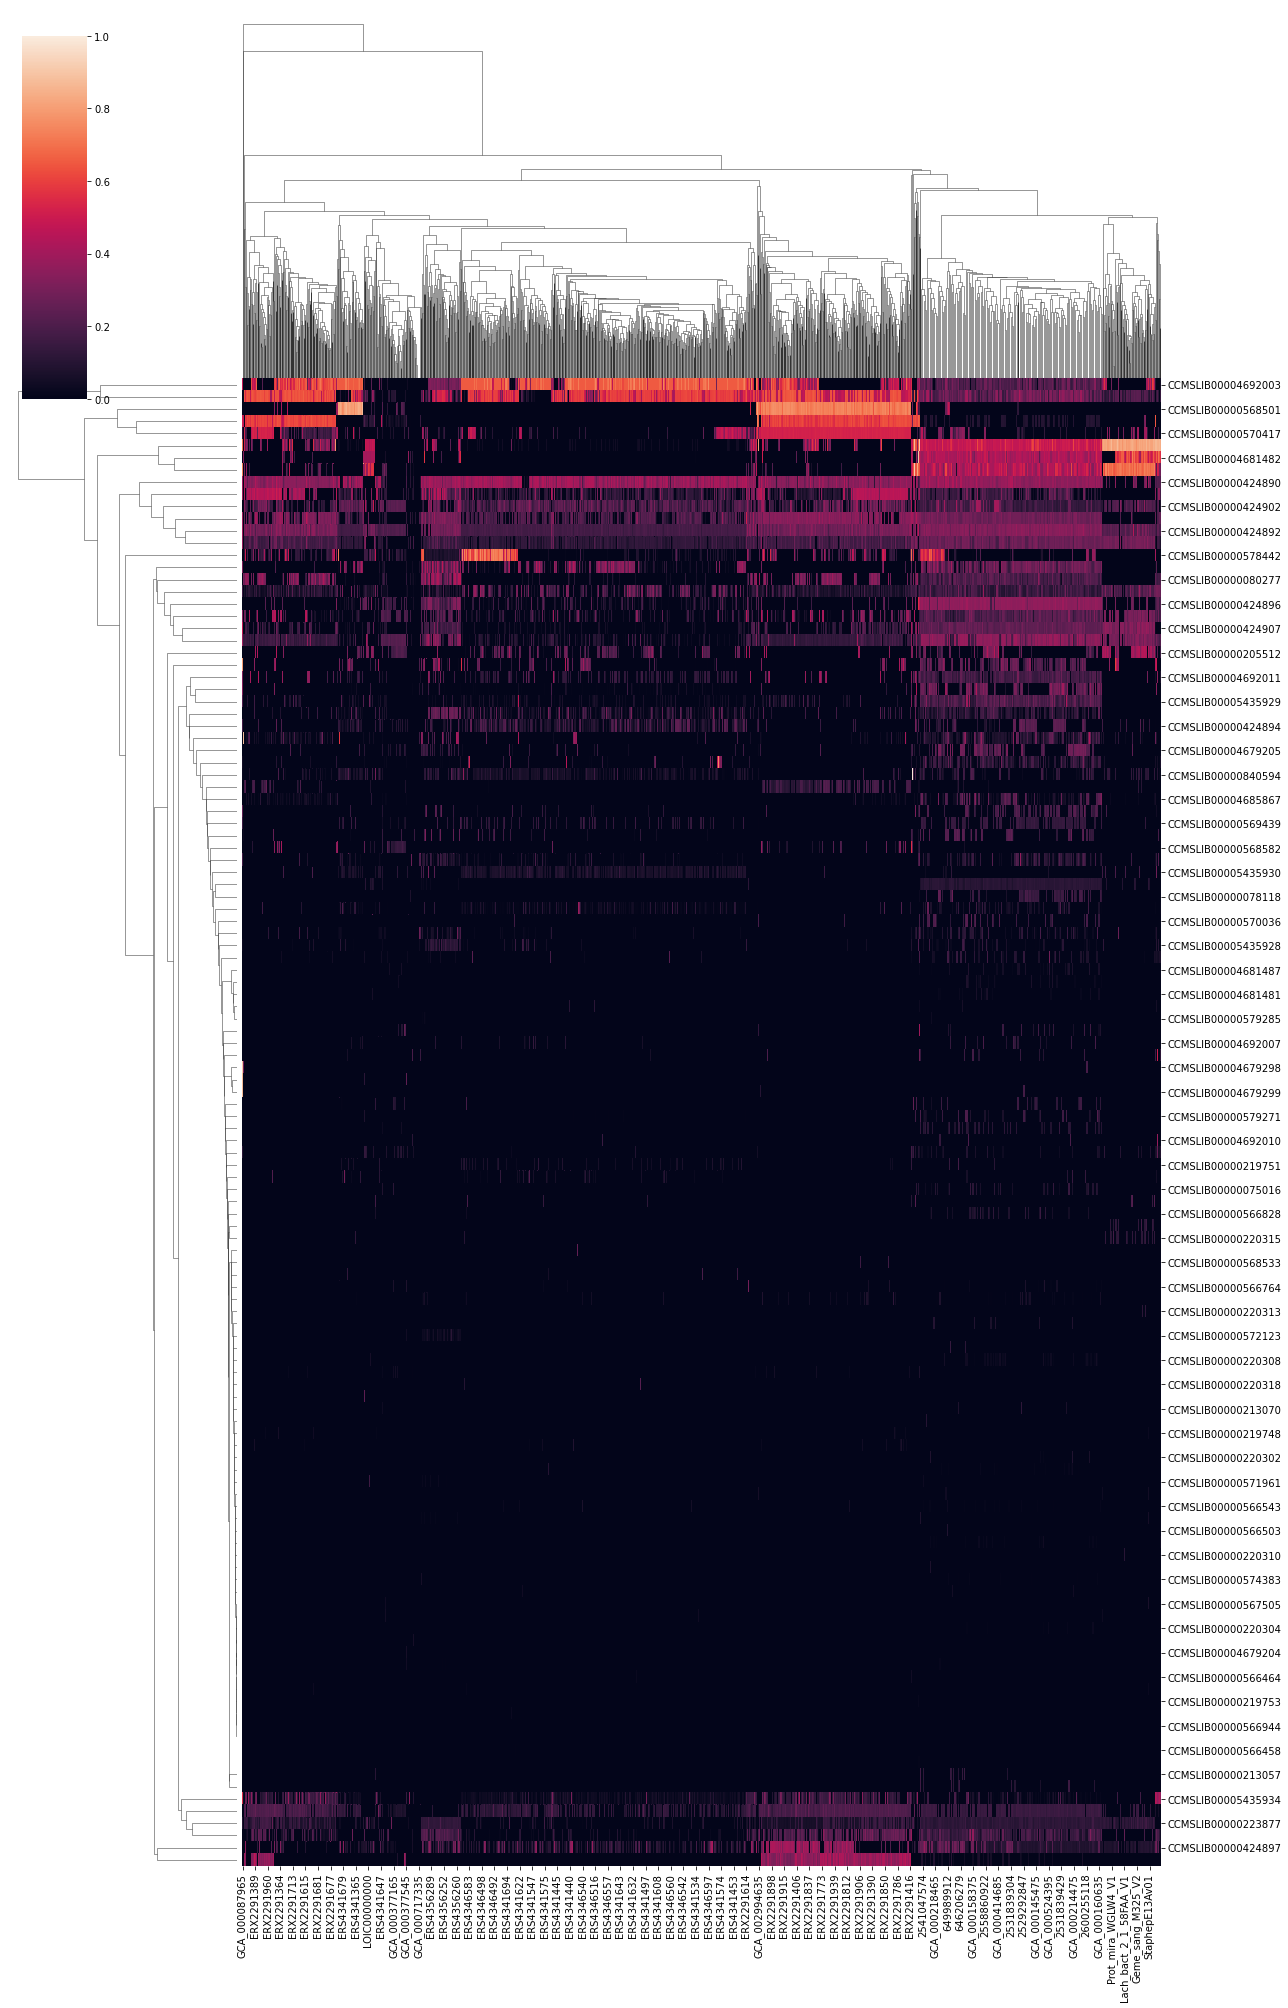

In [28]:
sns.clustermap(merged_ispec_mat,figsize=[18,28])